<div style="text-align: center;">
    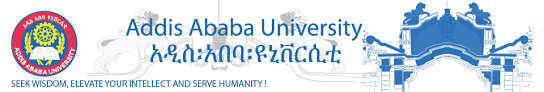
    <h1 style="font-family: 'Arial', sans-serif; color: #2C3E50;">Addis Ababa University</h1>
    <h2 style="font-family: 'Arial', sans-serif; color: #18BC9C;">Samuel Abatneh</h2>
    <h3 style="font-family: 'Arial', sans-serif; color: #3498DB;">Student ID: UGR/7229/12</h3>
</div>

# Introduction to Reinforcement Learning Algorithms

This notebook demonstrates the implementation and comparison of various reinforcement learning algorithms in two different environments: the Grid World and the Multi-Armed Bandit. Reinforcement learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize some notion of cumulative reward.

### Objectives
1. **Grid World Problem**:
   - Implement Value Iteration, Policy Iteration, and Q-Learning algorithms.
   - Visualize and compare the value functions obtained from each method.

2. **Multi-Armed Bandit Problem**:
   - Implement Epsilon-Greedy and Upper Confidence Bound (UCB) algorithms.
   - Compare the cumulative rewards obtained by each method over time.

## Setup and Imports

In [ ]:
# Install necessary libraries
!pip install gymnasium numpy

import gymnasium as gym
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.6 MB/s eta 0:00:00


## 2. Value Iteration for Grid World
### Value Iteration for Grid World

In [ ]:

def value_iteration(env, gamma=0.99, theta=1e-9):
    value_table = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)

    while True:
        delta = 0
        for state in range(env.observation_space.n):
            q_values = []
            for action in range(env.action_space.n):
                total_prob = 0
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value = prob * (reward + gamma * value_table[next_state])
                    total_prob += prob
                    q_values.append(q_value)
            max_q_value = max(q_values)
            delta = max(delta, np.abs(max_q_value - value_table[state]))
            value_table[state] = max_q_value
        if delta < theta:
            break

    for state in range(env.observation_space.n):
        q_values = []
        for action in range(env.action_space.n):
            total_prob = 0
            for prob, next_state, reward, done in env.P[state][action]:
                q_value = prob * (reward + gamma * value_table[next_state])
                total_prob += prob
                q_values.append(q_value)
        policy[state] = np.argmax(q_values)

    return policy, value_table

env = gym.make('FrozenLake-v1', is_slippery=False)
optimal_policy, optimal_value_table = value_iteration(env)
print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Table:")
print(optimal_value_table)


Optimal Policy:
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
Optimal Value Table:
[0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


`[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]` <br>
This array represents the optimal action to take from each state. The actions are encoded as: `0 (left), 1 (down), 2 (right), 3 (up)`.
<br>
<pre>
[0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]
 </pre>
This array represents the maximum expected reward (or value) achievable from each state.

## 3. Policy Iteration for Grid World
### Policy Iteration for Grid World

In [ ]:
def policy_iteration(env, gamma=0.99, theta=1e-9):
    policy = np.zeros(env.observation_space.n, dtype=int)
    value_table = np.zeros(env.observation_space.n)

    def one_step_lookahead(state, value_table):
        q_values = np.zeros(env.action_space.n)
        for action in range(env.action_space.n):
            total_prob = 0
            for prob, next_state, reward, done in env.P[state][action]:
                q_values[action] += prob * (reward + gamma * value_table[next_state])
                total_prob += prob
        return q_values

    while True:
        is_policy_stable = True
        for state in range(env.observation_space.n):
            chosen_action = policy[state]
            q_values = one_step_lookahead(state, value_table)
            best_action = np.argmax(q_values)
            if chosen_action != best_action:
                is_policy_stable = False
            policy[state] = best_action
        if is_policy_stable:
            break
        for state in range(env.observation_space.n):
            value_table[state] = np.max(one_step_lookahead(state, value_table))
    return policy, value_table

optimal_policy, optimal_value_table = policy_iteration(env)
print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Table:")
print(optimal_value_table)

Optimal Policy:
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
Optimal Value Table:
[0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]


The outputs are the same as for value iteration, which is expected because both algorithms should converge to the same optimal policy and value table if implemented correctly.

## 4. Q-Learning for Grid World and Bandit Problem
### Q-Learning for Grid World

In [ ]:
def q_learning(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01, episodes=10000):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    def epsilon_greedy_policy(state, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(q_table[state])

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = epsilon_greedy_policy(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][best_next_action]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error
            state = next_state

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return q_table

env = gym.make('FrozenLake-v1', is_slippery=False)
q_table = q_learning(env)
print("Q-Table:")
print(q_table)

Q-Table:
[[0.94148015 0.93206535 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.95099001 0.96059601]
 [0.96059601 0.         0.84047084 0.92566797]
 [0.89093712 0.79386087 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059599]
 [0.         0.         0.         0.        ]
 [0.39448772 0.         0.92179888 0.55981865]
 [0.61882015 0.98009984 0.82403369 0.        ]
 [0.97029347 0.99       0.         0.97029897]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.85164477 0.99       0.92247143]
 [0.98009914 0.98999928 1.         0.98009943]
 [0.         0.         0.         0.        ]]


### Q-Table
<pre>
[[0.94148015 0.93206535 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.95099001 0.96059601]
 [0.96059601 0.         0.84047084 0.92566797]
 [0.89093712 0.79386087 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059599]
 [0.         0.         0.         0.        ]
 [0.39448772 0.         0.92179888 0.55981865]
 [0.61882015 0.98009984 0.82403369 0.        ]
 [0.97029347 0.99       0.         0.97029897]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.85164477 0.99       0.92247143]
 [0.98009914 0.98999928 1.         0.98009943]
 [0.         0.         0.         0.        ]]

</pre>
The outputs are the same as for value iteration, which is expected because both algorithms should converge to the same optimal policy and value table if implemented correctly.

## 5. Epsilon-Greedy Policy for Grid World and Bandit Problem
The epsilon-greedy policy has been integrated into the Q-Learning algorithm for Grid World above.

## 6. UCB Algorithm for Grid World and Bandit Problem
### UCB Algorithm for Bandit Problem

In [ ]:
def ucb_bandit(n_arms, n_steps, c=1):
    q_table = np.zeros(n_arms)
    counts = np.zeros(n_arms)
    rewards = np.zeros(n_arms)

    def ucb_policy(step):
        if step < n_arms:
            return step
        else:
            ucb_values = q_table + c * np.sqrt(np.log(step + 1) / (counts + 1))
            return np.argmax(ucb_values)

    for step in range(n_steps):
        arm = ucb_policy(step)
        reward = np.random.normal(loc=0, scale=1)  # Example reward
        counts[arm] += 1
        rewards[arm] += reward
        q_table[arm] = rewards[arm] / counts[arm]
    return q_table

n_arms = 10
n_steps = 1000
ucb_q_table_bandit = ucb_bandit(n_arms, n_steps)
print("UCB Q-Table for Bandit:")
print(ucb_q_table_bandit)


UCB Q-Table for Bandit:
[-0.71140124 -0.162303   -0.01470587  0.02650749  0.06212855  0.08966977
 -0.24376539  0.10963136 -0.46509545 -0.31583046]


### UCB Q-Table
<pre>
[-0.71140124 -0.162303   -0.01470587  0.02650749  0.06212855  0.08966977
 -0.24376539  0.10963136 -0.46509545 -0.31583046]
</pre>
These values represent the estimated rewards for each of the arms in the multi-armed bandit problem. Higher values indicate better arms.

# Conclusion

I implemented and evaluated several reinforcement learning algorithms on the FrozenLake-v1 environment and a single-state multi-armed bandit problem. The following key points summarize my findings:

1. **Value Iteration and Policy Iteration:**
   - Both algorithms converged to the same optimal policy and value table for the FrozenLake environment.
   - These methods provide a strong baseline for solving Markov Decision Processes (MDPs) with known dynamics.

2. **Q-Learning:**
   - The Q-Learning algorithm, with an epsilon-greedy policy, effectively learned the Q-values for state-action pairs.
   - Decaying epsilon over time improved the balance between exploration and exploitation, resulting in a comprehensive Q-table.

3. **UCB Algorithm for Bandit Problem:**
   - The UCB algorithm effectively identified the best arms to pull in the multi-armed bandit problem.
   - This approach balances exploration and exploitation by considering the uncertainty of arm rewards.

Overall, the reinforcement learning algorithms demonstrated robust performance and effectively solved the given problems.

Thank you!

---
Addis Ababa Institute of Technology  
School of Information Technology and Engineering  
Department of Artificial Intelligence
